In [1]:
from matplotlib.dates import DateFormatter
from pathlib import Path
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import textwrap

plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.sans-serif']=['Segoe UI Emoji']

In [2]:
RUN_HEAVY = True

# Loading a single person's conversation

This hard codes the conversation, you can get the link by right clicking on the file you want and then chosing _Copy Relative Path_ and then pasting it in below.

In [3]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


rootdir = "fb_data/messages/inbox/lucyrimmer_pfwdzikwla/"

message_list = []
participants = []
for p in os.listdir(rootdir):
    path = os.path.join(rootdir, p)
    if Path(path).is_file():
        with open(path, "r") as fb_data:
            messages = json.load(fb_data, object_hook=parse_obj)
            participants = messages["participants"]
            message_list.extend(messages["messages"])


In [4]:
# message_list = messages["messages"]
df = pd.DataFrame(message_list)
df["datetime"] = df.timestamp_ms.apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
)


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


df["message_length"] = df.content.apply(get_message_length)
df.content = df.content.apply(replace_typographic_apostrophy)

print(df.shape)
df.sample(5)


(58110, 18)


,sender_name,timestamp_ms,content,share,type,is_unsent,photos,sticker,gifs,videos,reactions,call_duration,files,audio_files,ip,missed,datetime,message_length
10768,Lucy Rimmer,1595999881150,Also phoned the department of education and th...,NaN,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-29 15:18:01.150,140
7039,Lucy Rimmer,1604722606985,NaN,NaN,Generic,False,[{'uri': 'messages/inbox/lucyrimmer_pfwdzikwla...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-07 15:16:46.985,3
44917,Lucy Rimmer,1512816546571,Alone,NaN,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-09 21:49:06.571,5
35432,Lucy Rimmer,1539293735988,How was the gym?,NaN,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-12 08:35:35.988,16
55848,Lucy Rimmer,1424581722443,I'm so friggin tired,NaN,Generic,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-22 16:08:42.443,20


In [5]:
unsent = [m for m in message_list if m["is_unsent"]]
period_string = f"{df.datetime.min():%A %d %B, %Y} and {df.datetime.max():%A %d %B, %Y}"
print (
    f"Conversation between {participants[0]['name']} and {participants[1]['name']}.\n"
    f"Covering the period between {period_string}.\n"
    f"In this period there were {len(message_list)} messages, "
    f"{len([x for x in df.photos if x is not np.nan])} photos, "
    f"{len([x for x in df.videos if x is not np.nan])} videos, "
    # f"{len([x for x in df.audio_files if x is not np.nan])} audio files, "
    f"{len(unsent)} messages were unsent"
)


Conversation between Lucy Rimmer and Ben Doherty.
Covering the period between Sunday 18 March, 2007 and Sunday 04 July, 2021.
In this period there were 58110 messages, 958 photos, 66 videos, 4 messages were unsent


Text(0.5, 1.0, 'Total number of messages sent between Sunday 18 March, 2007 and Sunday 04 July, 2021')

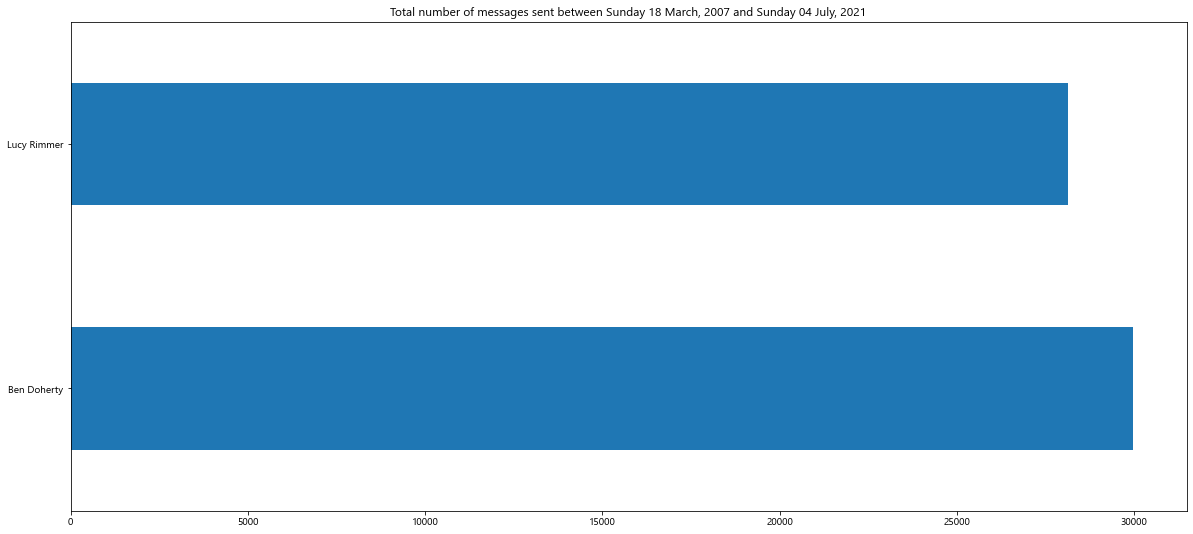

In [6]:
df.sender_name.value_counts().plot.barh()
plt.title(
    f"Total number of messages sent between {period_string}"
)


Text(0.5, 1.0, 'Types of message sent between Sunday 18 March, 2007 and Sunday 04 July, 2021')

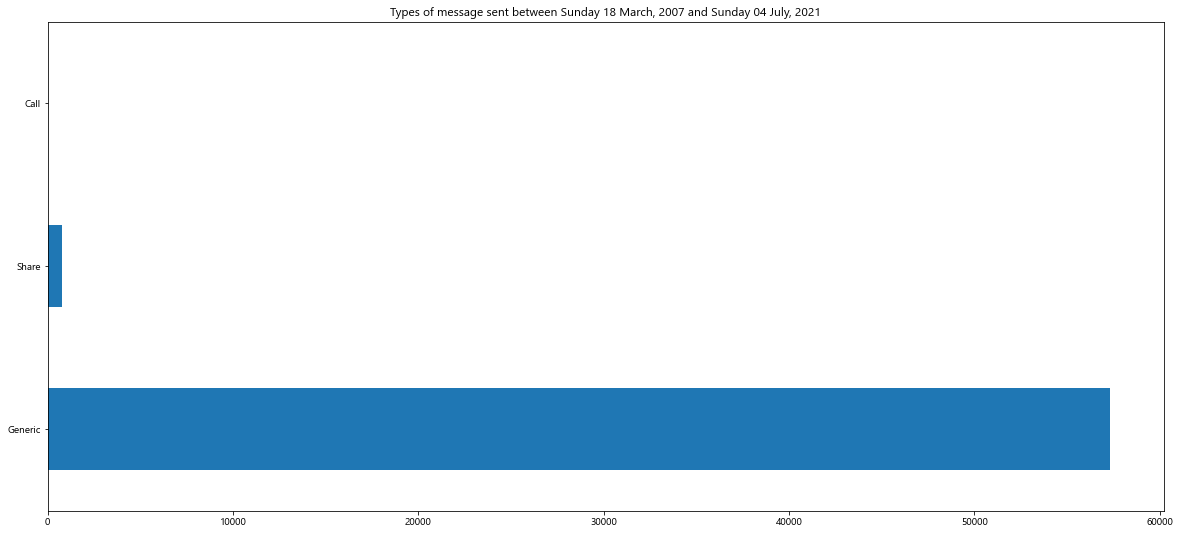

In [7]:
df["type"].value_counts().plot.barh()
plt.title(f"Types of message sent between {period_string}")


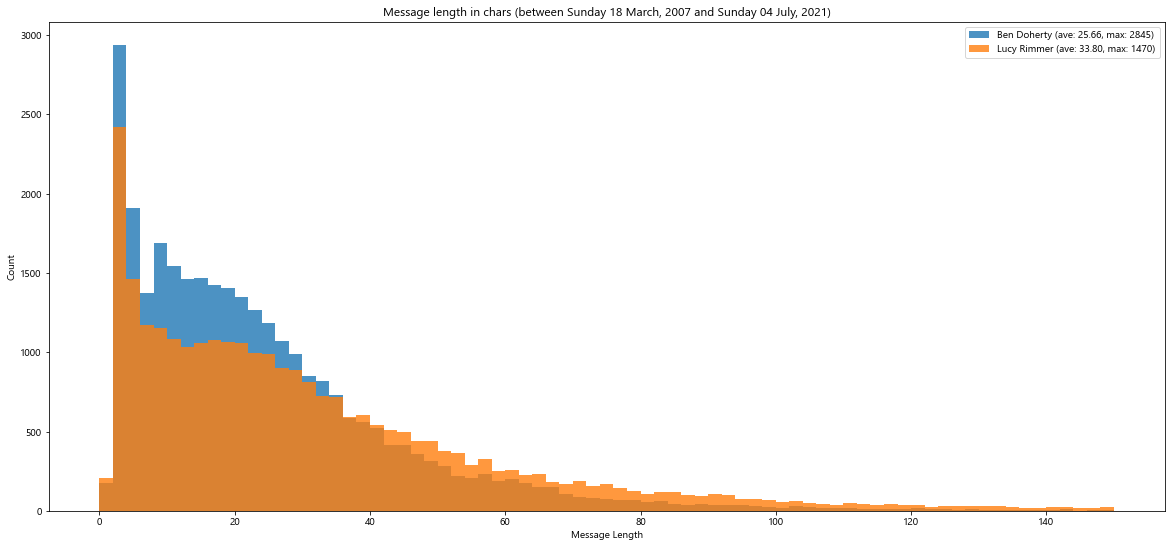

In [8]:
if RUN_HEAVY:
    plt.title(f"Message length in chars (between {period_string})")
    for name, data in df.groupby("sender_name"):
        ave_length = data.message_length.mean()
        max_length = data.message_length.max()
        plt.hist(
            data.message_length,
            bins=75,
            range=[0, 150],
            label=f"{name} (ave: {ave_length:.2f}, max: {max_length})",
            alpha=0.8,
        )
        plt.xlabel("Message Length")
        plt.ylabel("Count")
        plt.legend()


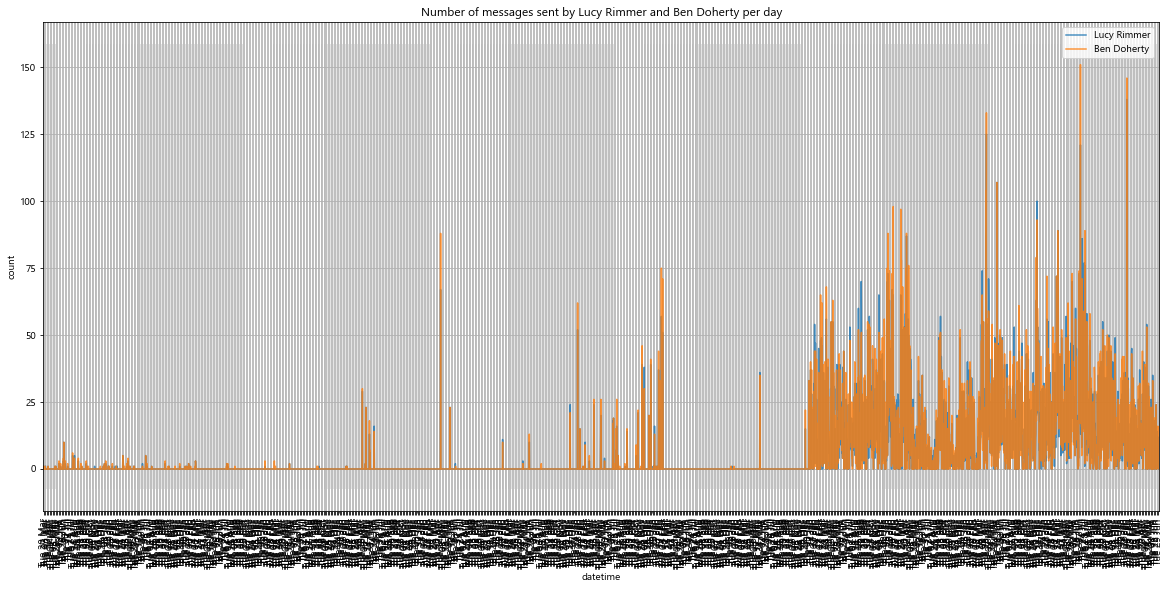

In [9]:
def messages_per_day(range=False):
    sender_a = participants[0]["name"]
    a_message_counts = (
        df[df.sender_name == sender_a]
        .set_index("datetime")
        .groupby(pd.Grouper(freq="D"))
        .count()
    )
    ax = a_message_counts.sender_name.plot(alpha=0.8, label=sender_a)
    sender_b = participants[1]["name"]
    b_message_counts = (
        df[df.sender_name == sender_b]
        .set_index("datetime")
        .groupby(pd.Grouper(freq="D"))
        .count()
    )
    b_message_counts.sender_name.plot(alpha=0.8, label=sender_b)
    plt.title(f"Number of messages sent by {sender_a} and {sender_b} per day")
    plt.ylabel("count")
    plt.legend()
    plt.grid(True)

    # Highlight the weekends
    # https://stackoverflow.com/a/66064136/1835727
    xmin, xmax = ax.get_xlim()
    days = np.arange(np.floor(xmin), np.ceil(xmax) + 2)  # range of days in date units
    weekends = [(dt.weekday() >= 5) | (dt.weekday() == 0) for dt in mdates.num2date(days)]
    ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor="k", alpha=0.1)
    if range:
        ax.set_xlim(range[0], range[1])  # set limits back to default values
    else:
        ax.set_xlim(xmin, xmax)  # set limits back to default values

    date_form = DateFormatter("%a %d %b")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.xticks(rotation=90)
    plt.show()

if RUN_HEAVY:
    messages_per_day()

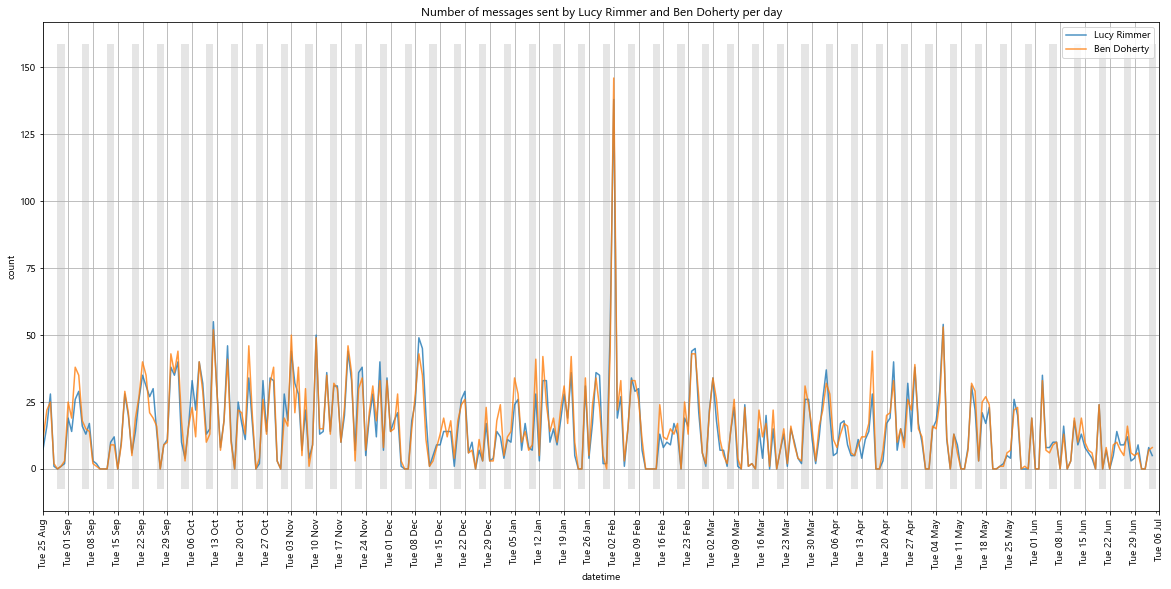

In [10]:
if RUN_HEAVY:
    messages_per_day(range=[18181+318, 18814] )

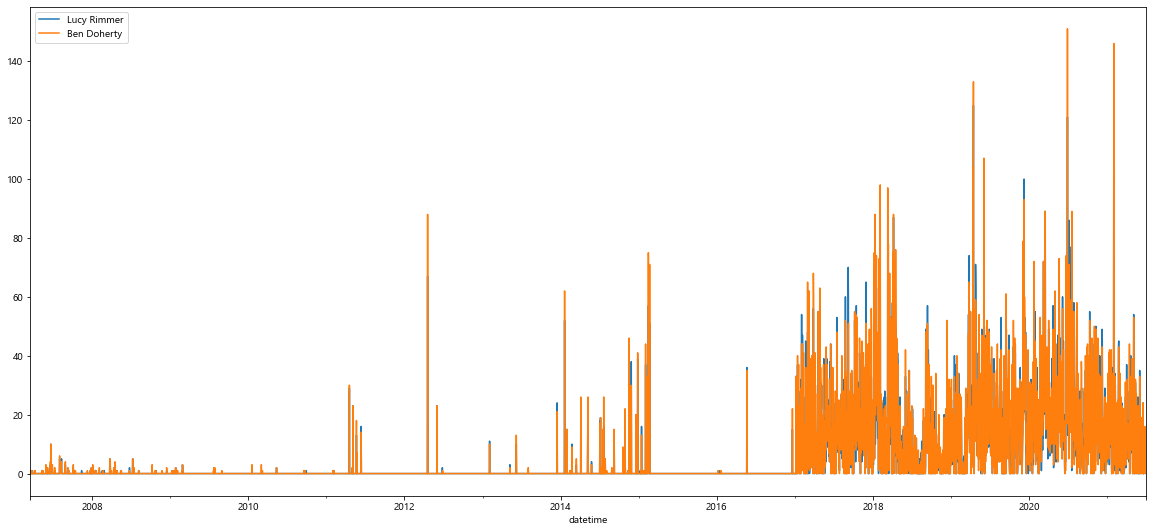

In [11]:
if RUN_HEAVY:
    p_a = participants[0]["name"]
    p_b = participants[1]["name"]
    day_counts = []
    for x, data in df.set_index("datetime").groupby(pd.Grouper(freq="D")):
        vc = data.sender_name.value_counts()

        dic = {"datetime": x, p_a: vc.get(p_a, 0), p_b: vc.get(p_b, 0)}
        day_counts.append(dic)
        # print(x,vc, dic)

    dc_df = pd.DataFrame(day_counts)
    dc_df.set_index("datetime", inplace=True)


    def make_ratio(row):
        try:
            a = row.get(p_a, 0)
            b = row.get(p_b, 0)
            if a > 0 and b > 0:
                r = a / b
            else:
                r = 0
            return r
        except:
            return 0


    dc_df["ratio"] = dc_df.apply(make_ratio, axis=1)
    dc_df.drop(["ratio"], axis=1).plot()


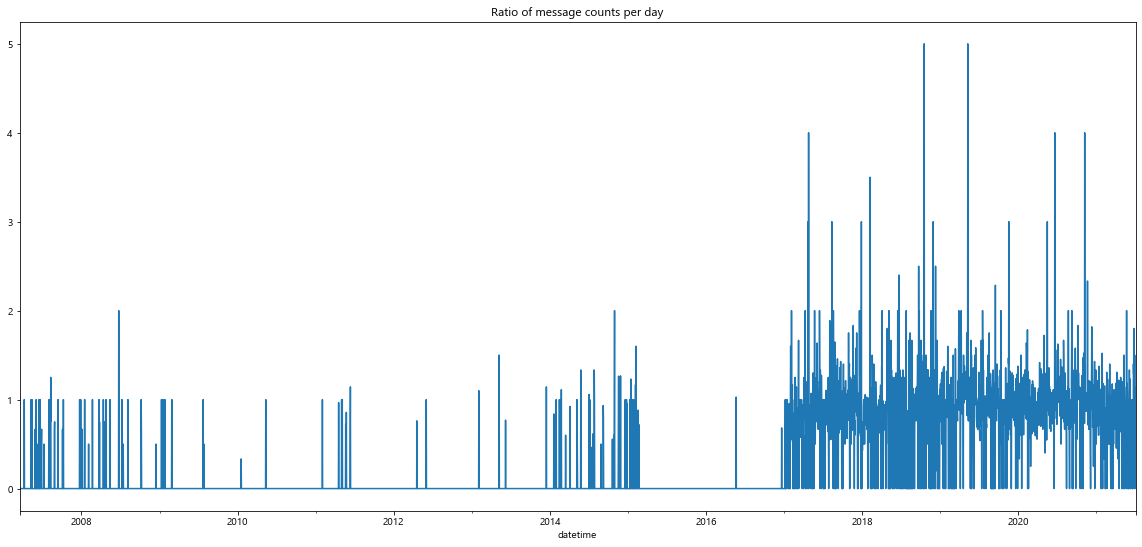

In [12]:
if RUN_HEAVY:
    dc_df.ratio.plot()
    plt.title("Ratio of message counts per day");

In [13]:
s = df.loc[df["datetime"].between("2021-06-01", "2021-06-5", inclusive=False)]
s[["sender_name", "content"]]


,sender_name,content
437,Ben Doherty,I'm pleased for you
438,Ben Doherty,Nice
439,Lucy Rimmer,And sipping free wine
440,Lucy Rimmer,Using brain again
441,Lucy Rimmer,Good
...,...,...
515,Lucy Rimmer,I'm on the train
516,Lucy Rimmer,Haha that's ok
517,Ben Doherty,How are you getting to the city?
518,Ben Doherty,"I typed ""How was your first day in the office?..."


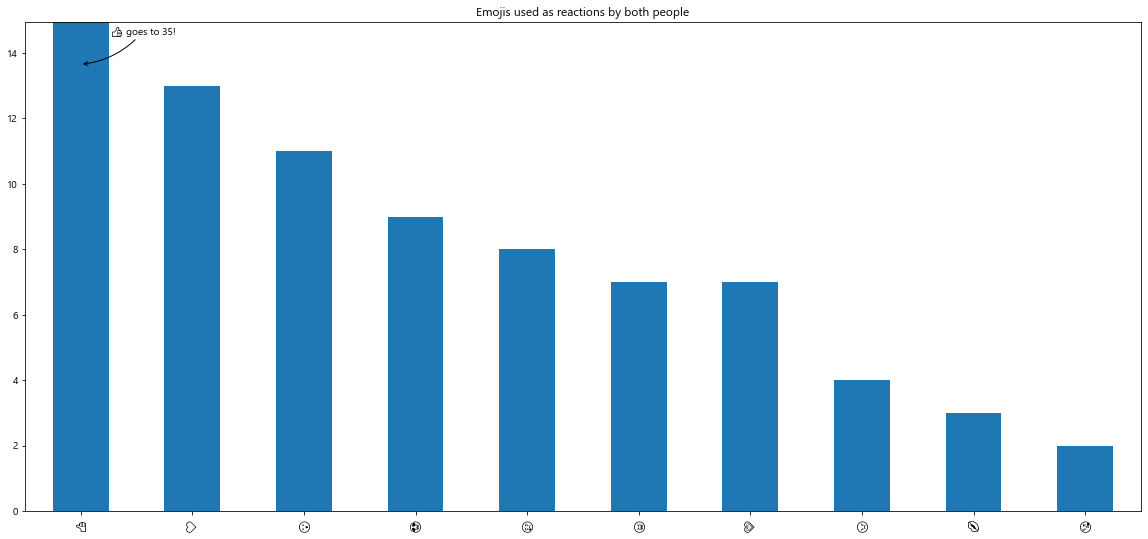

In [14]:
def get_reaction_emojis(reaction):
    if type(reaction) is list:
        emojis = [r["reaction"] for r in reaction]
        return "".join(emojis)
    else:
        return reaction


df["reaction_emojis"] = df.reactions.apply(get_reaction_emojis)

if RUN_HEAVY:
    vc = df.reaction_emojis.value_counts()
    plt.title(f"Emojis used as reactions by both people")
    ax = vc[vc > 1].plot.bar()
    ax.set_ylim(0, vc[1]*1.15)
    plt.annotate(
        f"{vc.index[0]} goes to {vc[0]}!",
        (0, vc[1]*1.05),
        xycoords="data",
        xytext=(30, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color="k"),
    )


Emojis used, in descending order of frequency:  👍,❤,😆,😠,😮,🤣,🥰,😢


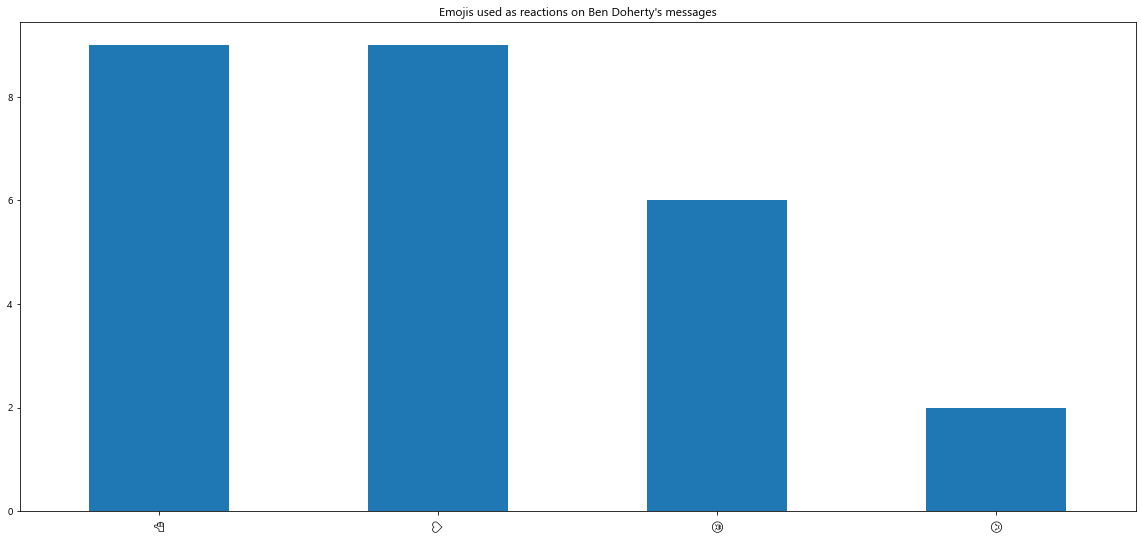

Emojis used, in descending order of frequency:  👍,😮,😍,😢,💗,❤,💋,😠,😘,😆,🦟,🔥,♟️,🍊,👙,😏,😛,🐬,🧠,👾,🍌,😋,☹️,💫


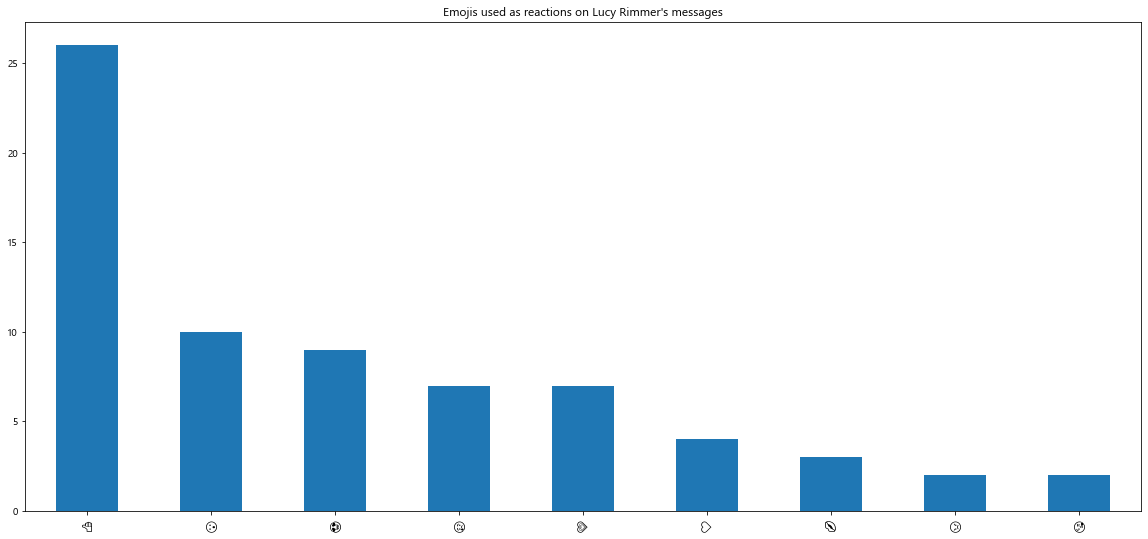

In [15]:
if RUN_HEAVY:
    for name, data in df.groupby("sender_name"):
        plt.title(f"Emojis used as reactions on {name}'s messages")
        all_response_emojis = [
            x for x in list(data.reaction_emojis.unique()) if x is not np.nan
        ]
        vc = data.reaction_emojis.value_counts()
        ae = ",".join(vc.index.to_list())
        print("Emojis used, in descending order of frequency: ",ae)
        vc[vc > 1].plot.bar()
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        plt.show()


In [16]:
def sumarise_convo(name, data):
    stop_words = [
        "that's", "i", "i'm", "i'd", "i'll", "it's", "i've", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", 
        "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", 
        "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
        "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", 
        "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
        "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", 
        "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
        "s", "t", "can", "will", "just", "don", "should", "now"
    ]  # From: https://gist.github.com/sebleier/554280
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    clean_words = [
        x.lower() for x in words[name].split(" ") if x.lower() not in stop_words
    ]
    unique_words = set(words[name].split(" "))
    print(
        f"Between {period_string}, {name} wrote {wordcount} words ({len(words[name])} characters)"
        f" and used {len(unique_words)} different words."
    )
    # print(unique_words)

    word_freq = pd.Series(clean_words).value_counts()
    top = 40
    # print(word_freq.iloc[:top])
    try:
        word_freq.iloc[:top].plot.barh()
        plt.title(f"{name}'s top {top} most used words")
        plt.tight_layout()
        plt.savefig(f"convo_graphs/{name}'s most used words")
        plt.show()
    except Exception as e:
        print(name, e)


Between Sunday 18 March, 2007 and Sunday 04 July, 2021, Ben Doherty wrote 148225 words (795362 characters) and used 18344 different words.


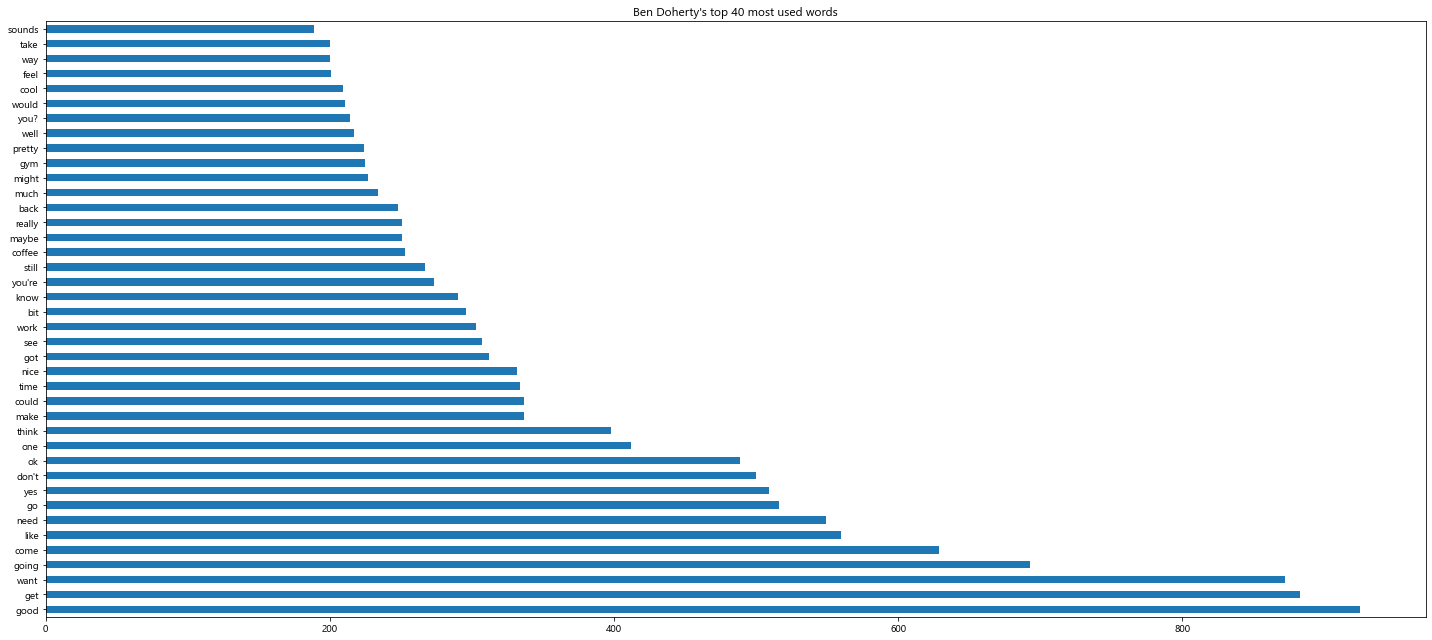

Between Sunday 18 March, 2007 and Sunday 04 July, 2021, Lucy Rimmer wrote 191718 words (975622 characters) and used 16518 different words.


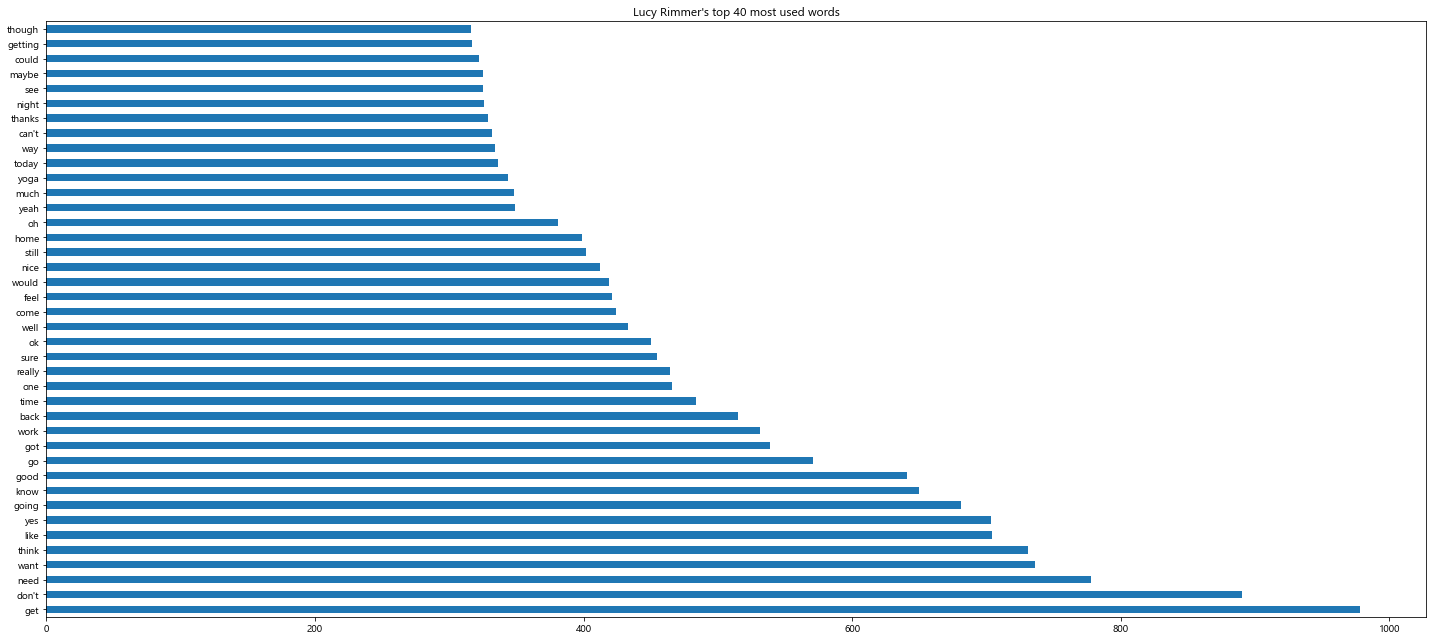

In [17]:
if RUN_HEAVY:
    for name, data in df.groupby("sender_name"):
        sumarise_convo(name, data)

In [18]:
def time_to_seconds(dt):
    t = dt.time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


df["date"] = df.datetime.apply(lambda x: x.date())
df["time"] = df.datetime.apply(lambda x: x.time())
df["seconds"] = df.datetime.apply(time_to_seconds)
df.sample(5)


,sender_name,timestamp_ms,content,share,type,is_unsent,photos,sticker,gifs,videos,...,files,audio_files,ip,missed,datetime,message_length,reaction_emojis,date,time,seconds
25294,Lucy Rimmer,1567928820657,This monstrosity was anchored in the harbour l...,NaN,Generic,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2019-09-08 17:47:00.657,55,NaN,2019-09-08,17:47:00.657000,64020
23437,Lucy Rimmer,1572743161718,I feel too sick,NaN,Generic,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2019-11-03 12:06:01.718,15,😮,2019-11-03,12:06:01.718000,43561
55323,Ben Doherty,1484774629582,"I don't feel very safe that way, I can't roll ...",NaN,Generic,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-01-19 08:23:49.582,72,NaN,2017-01-19,08:23:49.582000,30229
8405,Lucy Rimmer,1601949473260,I have a PT at 9am Tomorrow,NaN,Generic,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2020-10-06 12:57:53.260,27,NaN,2020-10-06,12:57:53.260000,46673
44657,Ben Doherty,1513904353940,I love a good wink,NaN,Generic,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-12-22 11:59:13.940,18,NaN,2017-12-22,11:59:13.940000,43153


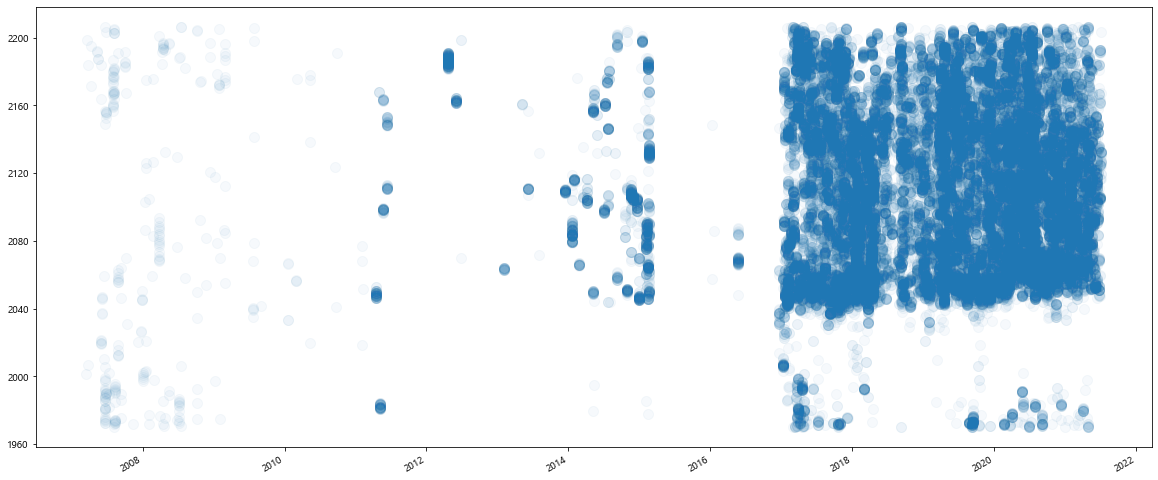

In [19]:
if RUN_HEAVY:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df.date, df.seconds, s=100, alpha=0.04)
    ax.yaxis_date()
    fig.autofmt_xdate()

    plt.show()


So, this makes sense to me, but it's a bit gross. The y axis is all messed up, it should be showing time, not number of seconds. I'm also not sure if time goes forward up or down the page.

It'd be good to work out a way of identifying sleep periods. Maybe that's a period that starts after 10pm that's offline for more than 4 hours?

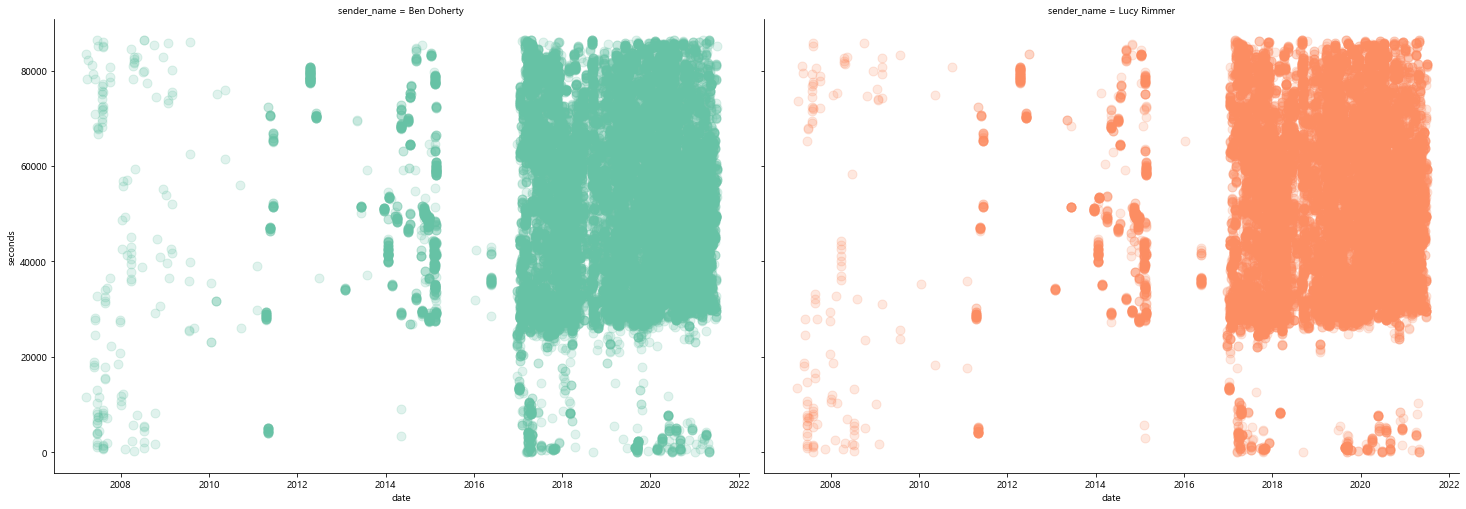

In [20]:
if RUN_HEAVY:
    plot = sns.lmplot(
        x="date",
        y="seconds",
        data=df,
        # data=all_convo_df,
        hue="sender_name",
        fit_reg=False,
        legend=True,
        palette="Set2",
        col="sender_name",
        col_wrap=4,
        scatter_kws=dict(s=80, alpha=0.2),
        height=7,
        aspect=10 / 7,
    )


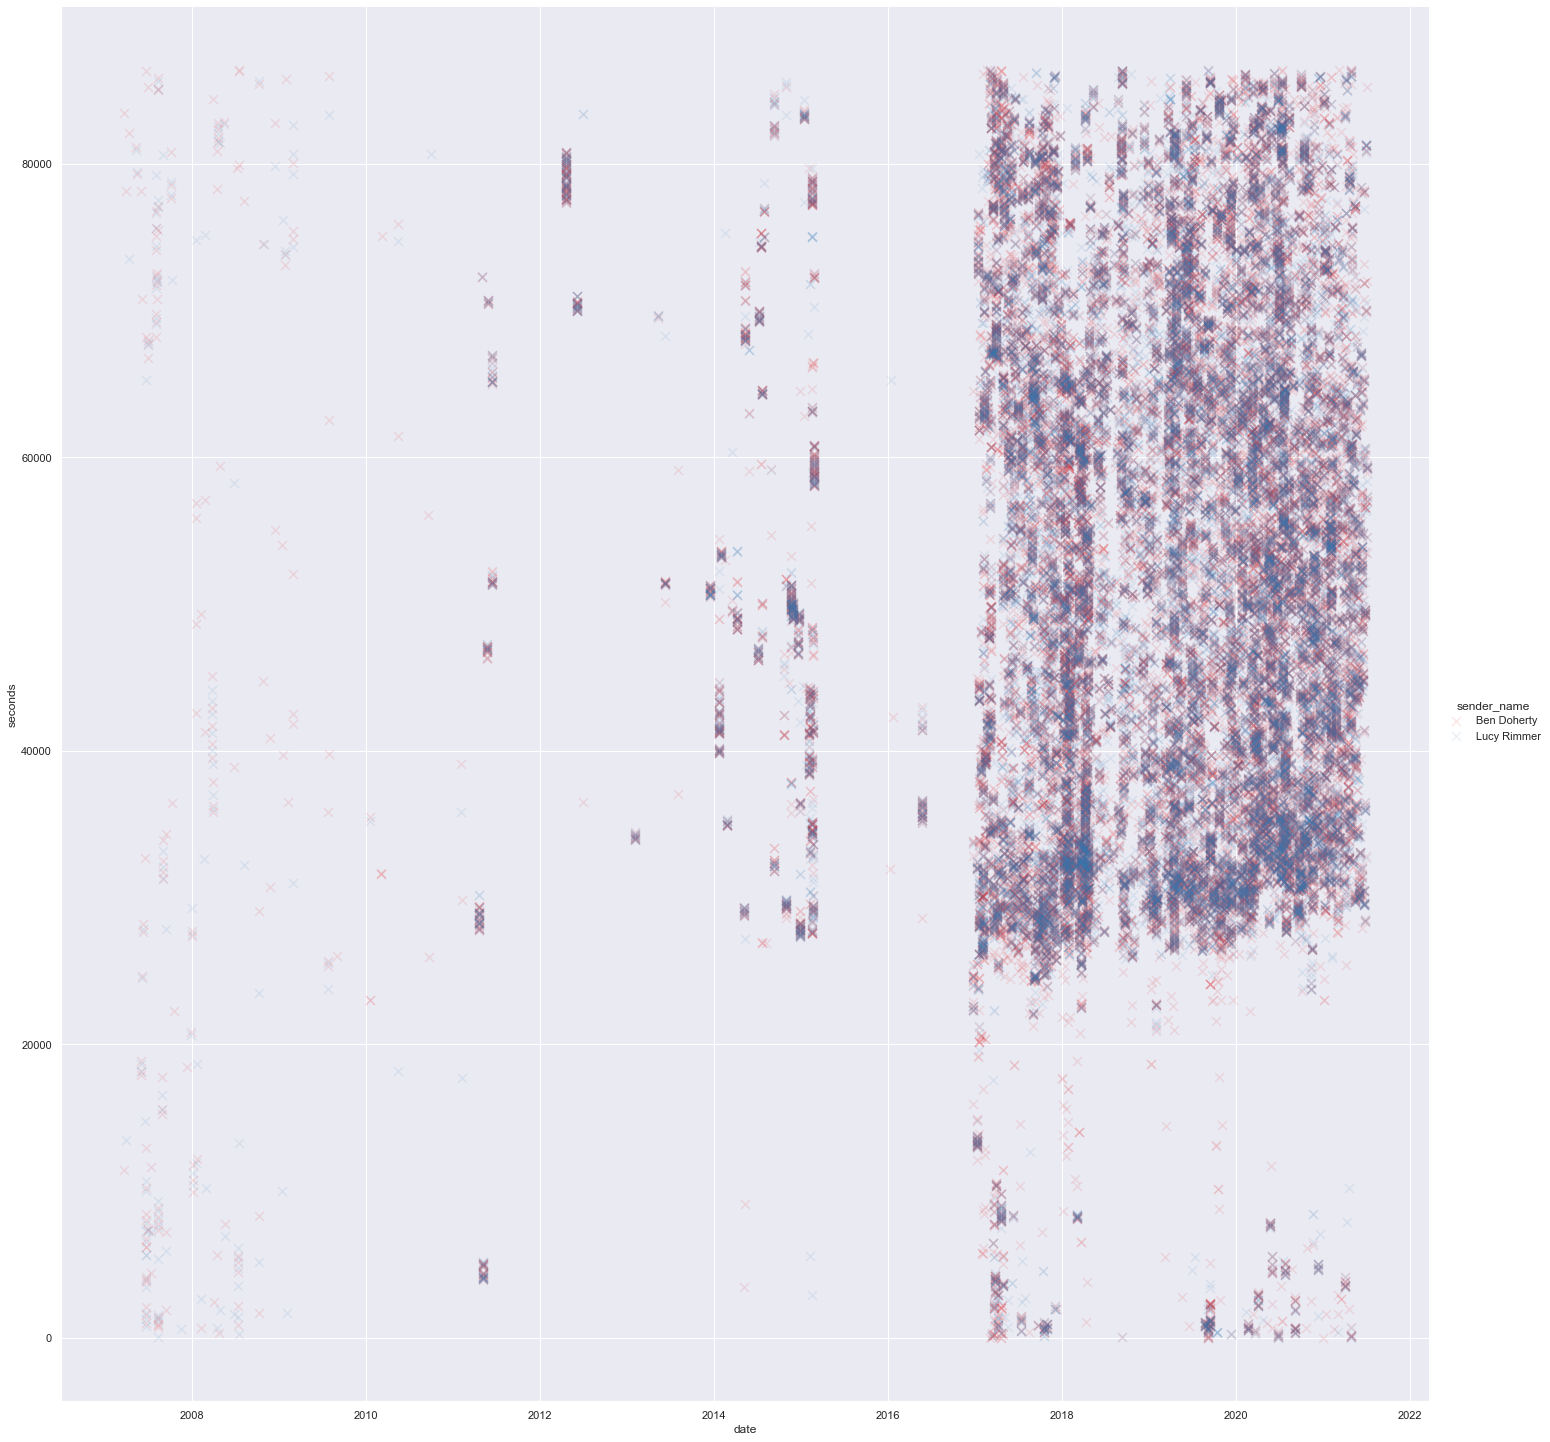

In [21]:
if RUN_HEAVY:
    sns.set(rc={"figure.figsize": (10, 10)})
    plot = sns.lmplot(
        x="date",
        y="seconds",
        data=df,
        hue="sender_name",
        markers=["x", "x"],
        fit_reg=False,
        legend=True,
        palette="Set1",
        scatter_kws=dict(s=80, alpha=0.1),
        height=20,
        aspect=20 / 20,
    )
    # plt.xticks(rotation=45);


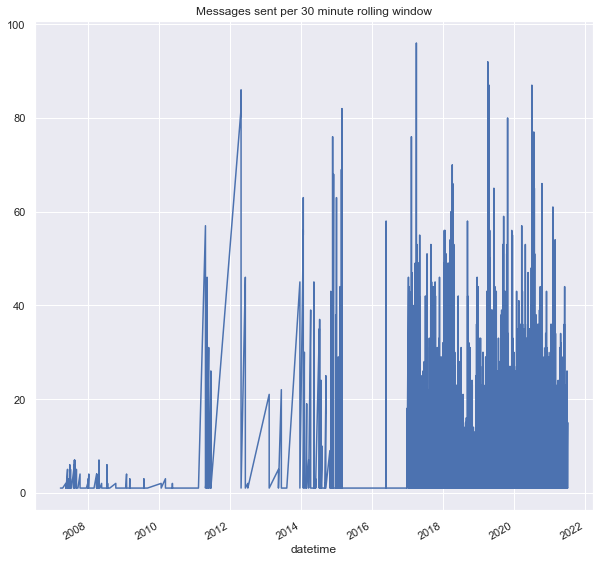

In [22]:
try:
    df.set_index("datetime", inplace=True)
except:
    pass # already set
df["window_30min"] = df['sender_name'].rolling("30min").count()
if RUN_HEAVY:
    df.window_30min.plot()
    plt.title("Messages sent per 30 minute rolling window")

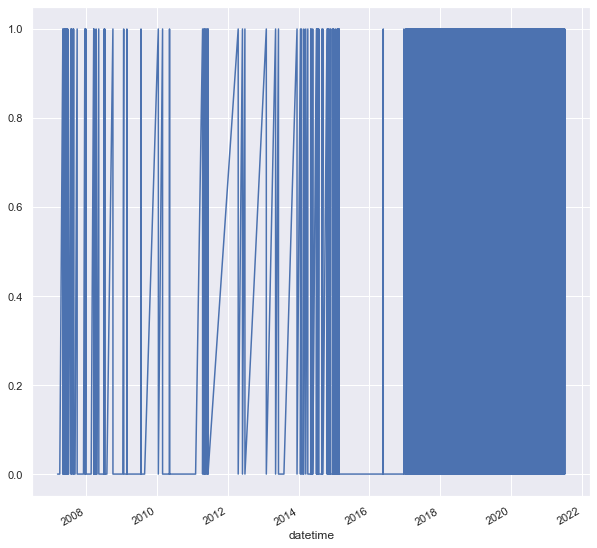

In [23]:
if RUN_HEAVY:
    df["binary_convo_in_window"] = df.window_30min.apply(lambda x: 0 if x<2 else 1)
    df.binary_convo_in_window.plot()

In [24]:
def contains_convo(ser):
    """Mark a rolling window if it contains a "conversation" or not.

    The rolling apply is a bit unintuitive as it passes only the index, not the 
    section of data frame that we're interested in. We need to use the index to 
    get the bit of the main DF that we're interested in, out of it.

    The definition of a conversation is pretty basic, more than one person, more 
    than 3 messages, in the time window.

    Args:
        ser (pd.core.series.Series): The section of the index that is the window

    Returns:
        int: 1 for True, 0 for False
    """
    
    rows = df.loc[ser.index]
    # print(rows.shape, rows.sender_name.unique())
    try:
        if rows.shape[0] < 3:
            # conversation must have more than 3 messages
            return 0
        elif len(rows.sender_name.unique()) <= 1:
            # conversation must have more than one person in it
            return 0
        else:
            return 1
    except Exception as e:
        print(e)
        return 0


# df["fancy_binary_convo_in_window"]
# temp = df.iloc[:5000]
# print(temp.head(2))
# print(temp.shape)
x = df.rolling("30min").apply(contains_convo, raw=False)["timestamp_ms"]
# Arbitrary column
x.head()


datetime
2021-07-04 23:40:44.446    0.0
2021-07-04 20:00:59.667    0.0
2021-07-04 15:56:13.560    0.0
2021-07-04 15:55:33.352    0.0
2021-07-04 15:55:27.374    1.0
Name: timestamp_ms, dtype: float64

<AxesSubplot:xlabel='datetime'>

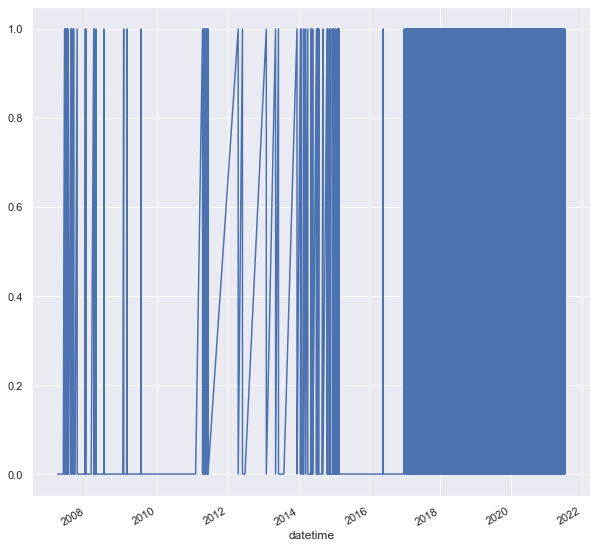

In [25]:
x.plot()